# **1. Matériel : vérifier que le GPU est bien sélectionné**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 18 13:13:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **2. Importation des librairies**

In [ ]:
import sys,os
import torch, torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary

from torch import Tensor
from functools import partial

from torchvision.transforms._presets import ImageClassification
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# **3. Importation des données**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
folder='/content/drive/MyDrive/Workshop/' #@param ['/content/drive/MyDrive/Workshop/','/content/drive/MyDrive/IA/UMONS/Workshop/']

image_classification_path = f'{folder}2. Image classification'

training_path=   image_classification_path + '/' + 'data'
testing_path = image_classification_path + '/' + 'test'
sys.path.append(image_classification_path)
os.chdir(image_classification_path)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **4. Paramètres**

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
batch_size="32" #@param [16,32]
batch_size = int(batch_size)
validation_split = 0.1
seed = 50 #@param

# **5. Visualiser une image**

In [ ]:
transformView = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    #transforms.RandomRotation(15),       # Randomly rotate the images by +/- 15 degrees
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

datasetView = datasets.ImageFolder(training_path, transformView)
dataloaderView = torch.utils.data.DataLoader(datasetView, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(root=testing_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from collections import Counter

# Count the number of instances per class
class_counts = Counter(datasetView.targets)
total_images = len(datasetView)

# Calculate the proportion of each class
class_proportions = {datasetView.classes[i]: count / total_images for i, count in class_counts.items()}

# Print the class proportions
print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")

Class Proportions:
fire: 0.37
no_fire: 0.34
start_fire: 0.29


In [ ]:
from torch.utils.data import random_split

total_size = len(datasetView)
train_size = int(total_size * (1 - validation_split))
validation_size = total_size - train_size

torch.manual_seed(seed)
train_dataset, validation_dataset = random_split(datasetView, [train_size, validation_size])

# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

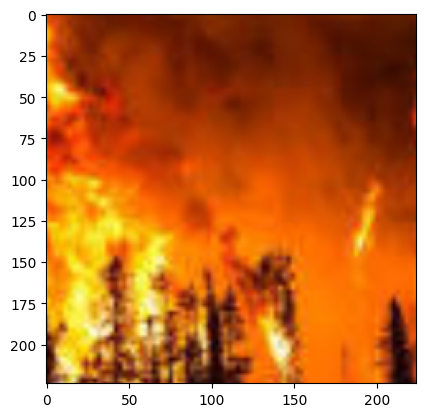

In [ ]:
images,labels = next(iter(dataloaderView))
imshow(images[0].permute(1, 2, 0))

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet(num_classes):
    # Load a pre-trained ResNet18 model
    model = models.resnet152(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer with a new one with `num_classes` outputs
    num_ftrs = model.fc.in_features
    # Create a new classifier with additional layers
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(32, num_classes),  # Use num_classes here to make it flexible
        nn.Softmax(dim=1)
    )

    return model

def create_squeezenet(num_classes):
    # Load a pre-trained SqueezeNet model
    model = models.squeezenet1_1(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # SqueezeNet uses a final Conv2d layer as the classifier
    # The final classifier is a Conv2d layer in the 'classifier' module
    final_conv = nn.Conv2d(512, num_classes, kernel_size=(1,1))

    # Replace the classifier module
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        final_conv,
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )

    # Change the forward pass of the classifier to output the class scores directly
    model.num_classes = num_classes
    model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), num_classes)

    return model

def create_mobilenet(num_classes):
    # Load a pre-trained MobileNetV2 model
    model = models.mobilenet_v2(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # MobileNetV2 uses 'classifier' instead of 'fc' used by ResNet
    # The last layer of MobileNetV2's classifier is a Linear layer with 1280 input features
    num_ftrs = model.classifier[1].in_features

    # Replace the classifier with a new one
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(32, num_classes),
        nn.Softmax(dim=1)  # Softmax for classification
    )

    return model

model = create_mobilenet(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.4MB/s]


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [ ]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)  # Optimize only the last layer

import torch

def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=3):
    model.to(device)  # Ensure model is on the correct device
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            print(train_loss)

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss /= len(validation_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%')

        test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return model

# Assuming base_model is defined and set up correctly with the final layers as needed
# Assuming train_loader and validation_loader are defined and loaded with the appropriate datasets
model = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=20)

35.091285705566406
70.31194686889648
104.73148345947266
139.14601516723633
173.5816879272461
206.7762451171875
240.56658172607422
273.93506240844727
305.9186897277832
340.0490531921387
371.77280044555664
404.72962951660156
436.46657371520996
466.75588035583496
497.5480213165283
531.3575191497803
563.7087955474854
595.126054763794
624.6568756103516
653.0834808349609
681.8592491149902
711.2922134399414
740.8088245391846
768.6687259674072
796.7624340057373
828.6921329498291
854.6577491760254
882.5145015716553
908.8004550933838
934.6602611541748
958.9321804046631
984.1507377624512
1015.2309913635254
1042.3122253417969
1070.8930053710938
1098.6758823394775
1125.6115417480469
1154.4040508270264
1183.181728363037
1208.9024448394775
1235.8269081115723
1261.7820377349854
1285.9627075195312
1313.9979572296143
1338.6886901855469
1361.493127822876
1389.6911506652832
1414.977891921997
1442.244701385498
1467.9276733398438
1492.9362926483154
1520.1291542053223
1544.589895248413
1571.7775421142578
159

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10, Train Loss: 0.9023, Train Acc: 67.07%, Validation Loss: 0.6929, Validation Acc: 87.20%
Test Loss: 0.7191, Test Accuracy: 84.83%
25.394882202148438
52.706295013427734
75.18927001953125
102.83410835266113
129.13641929626465
156.78449058532715
182.58628463745117
207.33537483215332
232.97522735595703
260.5444526672363
282.3281478881836
309.96659660339355
336.50847816467285
360.2484664916992
387.0746383666992
409.69101333618164
433.50311279296875
456.95611000061035
479.4373531341553
502.04969596862793
524.4159088134766
549.8881855010986
574.3098697662354
598.8652572631836
622.8529758453369
643.1876239776611
668.8298263549805
692.9896850585938
715.7183895111084
737.112943649292
762.0143547058105
784.2370452880859
807.9623928070068
832.8267593383789
855.837869644165
875.0336780548096
897.6112651824951
920.9988384246826
944.2930870056152
969.3920001983643
991.2240657806396
1011.7053699493408
1032.2897777557373
1053.8153915405273
1077.6233978271484
1100.569408416748
1122.58097839355

In [ ]:
test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
torch.save(model, 'model_tv_mobile2.pth')

In [ ]:
model = torch.load('model_tv_mobile2.pth')
model.eval()

test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6099, Test Accuracy: 94.24%


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
from torchvision import models
from pytorch_grad_cam import GradCAM

model.eval()

# Specify the target layer for ResNet
target_layers = [model.features[-1]]  # Last layer in the layer4 group

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=target_layers)

In [ ]:
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from torchvision import models

# Chargez et configurez le modèle
model = models.mobilenet_v2(pretrained=True)
model.eval()
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Définissez la transformation et chargez l'image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_path = '/content/drive/MyDrive/Workshop/2. Image classification/data/fire/00000050.jpg'
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)

# Appliquez GradCAM
grayscale_cam = cam(input_tensor=input_tensor)
print("Shape de grayscale_cam :", grayscale_cam.shape if grayscale_cam is not None else "None")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shape de grayscale_cam : (1, 224, 224)


In [ ]:
import cv2
import numpy as np

# Assuming grayscale_cam is the CAM mask and img is the original PIL image
rgb_img = np.array(img) / 255.0  # Normalize RGB image to [0, 1]

# Resize the CAM mask to match the image dimensions
grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

# Visualize the CAM
from pytorch_grad_cam.utils.image import show_cam_on_image
visualization = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

# Display the visualization
import matplotlib.pyplot as plt
plt.imshow(visualization)
plt.title('Grad-CAM Visualization')
plt.show()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


## end


In [ ]:
from torchvision import transforms
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load an image
image_path = '/content/drive/MyDrive/Workshop/2. Image classification/data/fire/00000050.jpg'
input_image = Image.open(image_path)

# Preprocess the image
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Make a prediction
with torch.no_grad():
    output = model(input_batch)

print(output)